# Infraestructure Manager revenue maximization with GSA

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from benchmarks.robin_railway import Solution, RevenueMaximization
from benchmarks.generator import get_revenue_behaviour
from src.entities import GSA

## WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [2]:
from pathlib import Path

supply_path = Path('/Users/david/PycharmProjects/robin/configs/ewgt23/supply_data.yml')

In [3]:
from robin.supply.entities import Supply

supply_data = Supply.from_yaml(path=supply_path)

In [4]:
print(supply_data.services[0])

Service id: 06301_06-09-2023-06.15 
	Date of service: 2023-09-06 
	Stops: ['60000', '71801'] 
	Line times (relative): [(0.0, 0.0), (150.0, 150.0)] 
	Line times (absolute): [('06:15', '06:15'), ('08:45', '08:45')] 
	Train Service Provider: [1, Renfe, ['1']] 
	Time Slot: [37510, 6:15:00, 6:25:00, 6:20:00, 0:10:00] 
	Rolling Stock: [1, S-114, {1: 250, 2: 50}] 
	Prices: 
		('60000', '71801'): {Básico: 15.0} 
	Tickets sold (seats): {Básico: 0} 
	Tickets sold (hard type): {1: 0, 2: 0} 
	Tickets sold per each pair (seats): {('60000', '71801'): {Básico: 0}} 
	Tickets sold per each pair (hard type): {('60000', '71801'): {1: 0}} 
	Capacity constraints: None 


In [6]:
service = supply_data.services[0]

In [16]:
service.id

'06301_06-09-2023-06.15'

In [17]:
time = service.id.split("-")[-1]
hour, minute = time.split(".")
delta = int(hour) * 60 + int(minute)

delta

375

In [12]:
service.schedule

[(datetime.timedelta(seconds=22500), datetime.timedelta(seconds=22500)),
 (datetime.timedelta(seconds=31500), datetime.timedelta(seconds=31500))]

In [21]:
sm = RevenueMaximization(supply_path, safe_headway=10)

In [22]:
sm.requested_schedule

{'06301_06-09-2023-06.15': {'60000': [375, 375], '71801': [525, 525]},
 '03063_06-09-2023-06.30': {'60000': [390, 390],
  '70600': [445, 446],
  '04040': [471, 472],
  '71801': [560, 560]},
 '03071_06-09-2023-07.00': {'60000': [420, 420], '71801': [570, 570]},
 '03073_06-09-2023-07.30': {'60000': [450, 450],
  '70200': [473, 474],
  '04040': [531, 532],
  '78400': [575, 577],
  '71500': [604, 606],
  '71801': [642, 642]},
 '03081_06-09-2023-08.00': {'60000': [480, 480], '71801': [630, 630]},
 '03083_06-09-2023-08.30': {'60000': [510, 510],
  '04040': [585, 586],
  '71801': [675, 675]},
 '03091_06-09-2023-09.00': {'60000': [540, 540], '71801': [690, 690]},
 '03093_06-09-2023-09.30': {'60000': [570, 570],
  '04040': [645, 646],
  '78400': [689, 691],
  '71500': [718, 720],
  '71801': [757, 765],
  '79300': [803, 805],
  '04307': [820, 820]},
 '06303_06-09-2023-10.30': {'60000': [630, 630],
  '04040': [704, 705],
  '71801': [795, 795]},
 '03113_06-09-2023-11.30': {'60000': [690, 690],
  '

In [23]:
gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
               is_feasible=sm.feasible_services_times,
               custom_repair=sm.custom_repair,
               r_dim=len(sm.boundaries.real),
               d_dim=0,
               boundaries=sm.boundaries)

In [24]:
import cProfile as profile
import time

pr = profile.Profile()
pr.disable()

gsa_algo.set_seed(seed=15)

pop_size = 20

start = time.time()
pr.enable()
training_history = gsa_algo.optimize(population_size=pop_size,
                                     iters=100,
                                     chaotic_constant=False,
                                     repair_solution=True,
                                     initial_population=sm.get_initial_population(pop_size))
pr.disable()
print(f"Elapsed time: {round(time.time() - start, 2)} seconds")

pr.dump_stats('profile.pstat')

GSA is optimizing  "get_fitness_gsa"
Scheduled trains: 20
Scheduled trains: 20
Scheduled trains: 22
Scheduled trains: 23
Scheduled trains: 24
['At iteration 1 the best fitness is 5347.400090323931']
Scheduled trains: 22
Scheduled trains: 23
Scheduled trains: 24
['At iteration 2 the best fitness is 5790.639445496287']
['At iteration 3 the best fitness is 5790.639445496287']
['At iteration 4 the best fitness is 5790.639445496287']
['At iteration 5 the best fitness is 5790.639445496287']
['At iteration 6 the best fitness is 5790.639445496287']
['At iteration 7 the best fitness is 5790.639445496287']
['At iteration 8 the best fitness is 5790.639445496287']
Scheduled trains: 25
['At iteration 9 the best fitness is 5888.85053147975']
['At iteration 10 the best fitness is 5888.85053147975']
['At iteration 11 the best fitness is 5888.85053147975']
['At iteration 12 the best fitness is 5888.85053147975']
['At iteration 13 the best fitness is 5888.85053147975']
Scheduled trains: 25
['At iteratio

In [20]:
import pandas as pd

from random import randint, seed 
from typing import Tuple

def run_gsa(chaotic_constant: bool=False,
            repair_solution: bool=True,
            runs: int=10,
            population_size: int=20,
            iterations: int=30
            ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    global_train_hist = pd.DataFrame()
    global_test_hist = pd.DataFrame(columns=["run", "fitness"])
    
    for k in range(runs):
        gsa_seed = randint(0, 1000)
        sm = RevenueMaximization(schedule, revenue, safe_headway=10)
        
        gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                       is_feasible=sm.feasible_services_times,
                       custom_repair=sm.custom_repair,
                       r_dim=len(sm.boundaries.real),
                       d_dim=0,
                       boundaries=sm.boundaries)
        
        gsa_algo.set_seed(seed=gsa_seed)
        training_history = gsa_algo.optimize(population_size=population_size,
                                     iters=iterations,
                                     chaotic_constant=chaotic_constant,
                                     repair_solution=repair_solution,
                                     initial_population=sm.get_initial_population(pop_size))
        
        training_history.insert(0, "run", k)
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        print(gsa_algo.solution_history[-1])
        fitness = training_history.iloc[-1]['Fitness']
        
        global_test_hist.loc[len(global_test_hist)] = [k, fitness]
        
        print("Fitness: ", fitness)
    
    return global_train_hist, global_test_hist

In [111]:
seed(28)

wa = 0.8
wf = 0.2
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    tr_df, tt_df = run_gsa(chaotic_constant=chaotic_constant,
                           runs=10)
    
    tr_df["chaotic_constant"] = chaotic_constant
    tt_df["chaotic_constant"] = chaotic_constant
    train_df = pd.concat([train_df, tr_df], axis=0)
    test_df = pd.concat([test_df, tt_df], axis=0)

Running GSA with chaotic constant:  True
GSA is optimizing  "get_fitness_gsa"
Scheduled trains: 31
Scheduled trains: 32
['At iteration 1 the best fitness is 6464.608284130071']
Scheduled trains: 30
Scheduled trains: 30
['At iteration 2 the best fitness is 6691.319327285762']
['At iteration 3 the best fitness is 6691.319327285762']
['At iteration 4 the best fitness is 6691.319327285762']
['At iteration 5 the best fitness is 6691.319327285762']
Scheduled trains: 31
['At iteration 6 the best fitness is 6737.671597509689']
Scheduled trains: 31
['At iteration 7 the best fitness is 6750.951575369593']
Scheduled trains: 31
['At iteration 8 the best fitness is 6873.412039575753']
['At iteration 9 the best fitness is 6873.412039575753']
['At iteration 10 the best fitness is 6873.412039575753']
['At iteration 11 the best fitness is 6873.412039575753']
['At iteration 12 the best fitness is 6873.412039575753']
['At iteration 13 the best fitness is 6873.412039575753']
['At iteration 14 the best fit

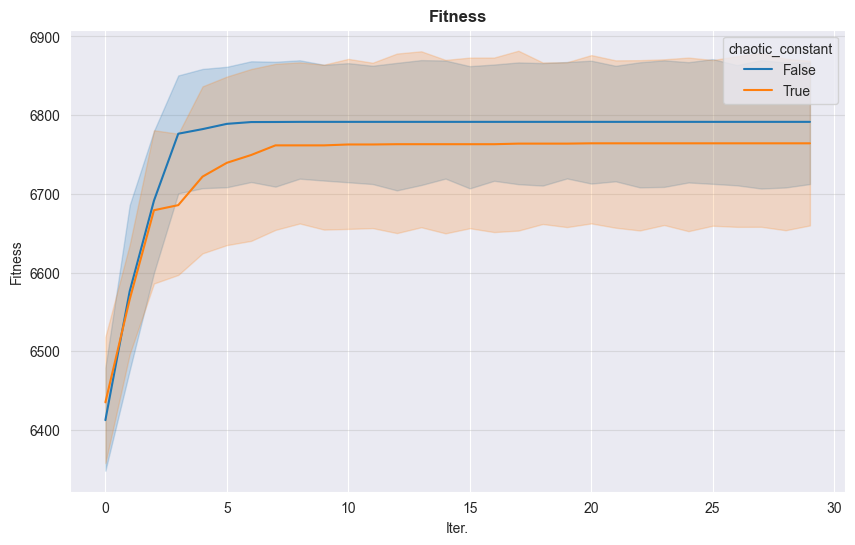

In [112]:
import seaborn as sns

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Fitness",
             hue="chaotic_constant",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [25]:
# Get last value in column 'Real' of training_history
best_solution_real = training_history.iloc[-1]['Real']
best_solution_real

array([ 371.,  389.,  447.,  474.,  425.,  449.,  476.,  541.,  586.,
        615.,  487.,  508.,  586.,  542.,  568.,  648.,  693.,  726.,
        771.,  813.,  626.,  704.,  690.,  750.,  779.,  825.,  855.,
        747.,  827.,  875.,  954.,  996.,  783.,  870.,  931.,  959.,
       1057., 1098.,  897.,  930.,  989., 1017., 1064., 1093.,  955.,
        987., 1065., 1164., 1215., 1024., 1049., 1077., 1136., 1184.,
       1214., 1076., 1109., 1185., 1247., 1139., 1299., 1341., 1170.,
       1194., 1235., 1261., 1309., 1338., 1384., 1424., 1241., 1266.,
       1307., 1333., 1379., 1409., 1268.])

In [26]:
sm.best_solution.real

array([ 371.,  389.,  447.,  474.,  425.,  449.,  476.,  541.,  586.,
        615.,  487.,  508.,  586.,  542.,  568.,  648.,  693.,  726.,
        771.,  813.,  626.,  704.,  690.,  750.,  779.,  825.,  855.,
        747.,  827.,  875.,  954.,  996.,  783.,  870.,  931.,  959.,
       1057., 1098.,  897.,  930.,  989., 1017., 1064., 1093.,  955.,
        987., 1065., 1164., 1215., 1024., 1049., 1077., 1136., 1184.,
       1214., 1076., 1109., 1185., 1247., 1139., 1299., 1341., 1170.,
       1194., 1235., 1261., 1309., 1338., 1384., 1424., 1241., 1266.,
       1307., 1333., 1379., 1409., 1268.])

In [36]:
best_solution = Solution(real=np.array(best_solution_real), discrete=sm.get_heuristic_schedule(np.array(best_solution_real)))

best_solution.real, best_solution.discrete

(array([ 371.,  389.,  447.,  474.,  425.,  449.,  476.,  541.,  586.,
         615.,  487.,  508.,  586.,  542.,  568.,  648.,  693.,  726.,
         771.,  813.,  626.,  704.,  690.,  750.,  779.,  825.,  855.,
         747.,  827.,  875.,  954.,  996.,  783.,  870.,  931.,  959.,
        1057., 1098.,  897.,  930.,  989., 1017., 1064., 1093.,  955.,
         987., 1065., 1164., 1215., 1024., 1049., 1077., 1136., 1184.,
        1214., 1076., 1109., 1185., 1247., 1139., 1299., 1341., 1170.,
        1194., 1235., 1261., 1309., 1338., 1384., 1424., 1241., 1266.,
        1307., 1333., 1379., 1409., 1268.]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]))

In [28]:
sm.is_feasible(best_solution, best_solution.discrete)

True

In [29]:
sm.get_fitness_gsa(best_solution_real)

(5905.51732218363, 0)

In [30]:
sm.get_revenue(best_solution)

5905.51732218363

In [31]:
sm.get_revenue(sm.best_solution)

5905.51732218363

In [32]:
sm.is_feasible(sm.best_solution, sm.best_solution.discrete)

True

In [33]:
sm.get_revenue(sm.best_solution)

5905.51732218363

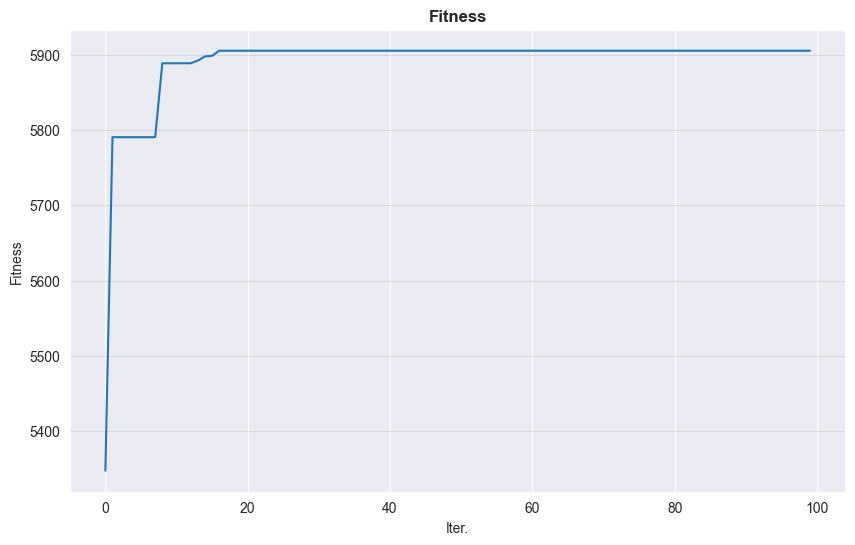

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=training_history,
             x="Iteration",
             y="Fitness",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [56]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [35]:
sum([sm.revenue[service]['canon'] for service in sm.revenue])

6836.5

In [104]:
training_history

,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,7863.690882,0,0.077843,[],"[1308, 1378, 1496, 1589, 609, 690, 807, 921, 9..."
1,1,8200.045549,0,0.334432,[],"[1302, 1371, 1491, 1586, 606, 687, 803, 916, 9..."
2,2,8428.372385,0,0.594928,[],"[1301, 1370, 1489, 1584, 603, 684, 801, 914, 9..."
3,3,8428.372385,0,0.861753,[],"[1301, 1370, 1489, 1584, 603, 684, 801, 914, 9..."
4,4,8447.990732,0,1.110731,[],"[1303, 1374, 1492, 1585, 604, 684, 803, 915, 9..."
...,...,...,...,...,...,...
95,95,8550.495681,0,21.481643,[],"[1304, 1372, 1491, 1586, 602, 684, 802, 915, 9..."
96,96,8550.495681,0,21.679128,[],"[1304, 1372, 1491, 1586, 602, 684, 802, 915, 9..."
97,97,8550.495681,0,21.877871,[],"[1304, 1372, 1491, 1586, 602, 684, 802, 915, 9..."
98,98,8550.495681,0,22.077040,[],"[1304, 1372, 1491, 1586, 602, 684, 802, 915, 9..."
